In [1]:
import sys
print("Python Version")
print(sys.version)

Python Version
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [2]:
#%matplotlib ipympl
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
import imageio

In [4]:
from importlib import reload

In [5]:
import lib

In [597]:
reload(lib)

<module 'lib' from '/home/xaedes/screeps-python/jupyterlab/lib.py'>

In [736]:
terrain = imageio.imread("bw_map_50px.png")
num_points = 20
points = lib.rand_points(terrain, num_points)
terrain_costs = lib.map_terrain_costs(terrain, {128:2,255:1})
cost_maps = np.array([
    lib.compute_cost_map(terrain_costs, point)
    for point in points
])
voronoi = lib.compute_voronoi(cost_maps)
voronoi_neighbors = lib.comute_voronoi_neighbors(voronoi)

In [737]:
voronoi_neighbors

{0: {1, 2, 4, 10, 11, 13, 17, 19},
 1: {0, 9, 10},
 2: {0, 4, 13, 14, 19},
 3: {5, 12, 14},
 4: {0, 2, 5, 13},
 5: {3, 4, 14},
 6: {7, 11, 15},
 7: {6, 11},
 8: {15},
 9: {1, 11, 17},
 10: {0, 1, 16, 19},
 11: {0, 6, 7, 9, 15, 17},
 12: {3, 14, 18},
 13: {0, 2, 4},
 14: {2, 3, 5, 12, 19},
 15: {6, 8, 11},
 16: {10},
 17: {0, 9, 11},
 18: {12},
 19: {0, 2, 10, 14}}

In [738]:
def compute_paths(cost_maps, points, voronoi_neighbors, w_eucl_cost=0.2, w_future_cost=0.3):
    num_points = points.shape[0]
    def compute_point_path(k,i):
        if k==i:
            return []
        elif i in voronoi_neighbors[k]:
            return lib.path_to(
                cost_maps[i], points[k], points[i], 
                w_eucl_cost=w_eucl_cost, 
                w_future_cost=w_future_cost
            )
        else:
            return None        
    paths = np.array([
        [compute_point_path(k,i) 
         for i in range(num_points)]
        for k in range(num_points)
    ])
    return paths

In [753]:
paths = compute_paths(cost_maps+1*np.random.uniform(0,0.25,cost_maps.shape), points, voronoi_neighbors,0.5,0.25)#,0,0)

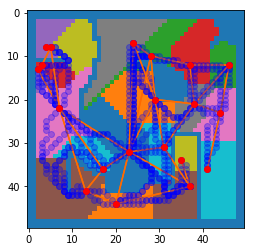

In [755]:
plt.imshow(voronoi,cmap=plt.cm.tab10)
for k,idcs in voronoi_neighbors.items():
    for i in idcs:
        plt.plot(
            [points[k,0],points[i,0]],
            [points[k,1],points[i,1]],
            color="#FF6A00"
        )
        path = paths[k,i]
        if path is not None:
            path = np.array(path)
            plt.plot(path[:,0],path[:,1],"o",color="blue",alpha=0.3)
plt.plot(points[:,0],points[:,1],"o",color="red")




In [756]:
def compute_path_distance_matrix(paths, points):
    num_points = points.shape[0]
    distance_matrix = np.array([
        [
            len(paths[k,i]) 
            if paths[k,i] is not None 
            else np.infty
            
            for i in range(num_points)
        ]
        for k in range(num_points)
    ])
    return distance_matrix

In [757]:
distance_matrix = compute_path_distance_matrix(paths, points)
distance_matrix

array([[ 0., 17., 13., inf, 26., inf, inf, inf, inf, inf, 17., 17., inf,
        26., inf, inf, inf,  7., inf,  9.],
       [17.,  0., inf, inf, inf, inf, inf, inf, inf,  8., 18., inf, inf,
        inf, inf, inf, inf, inf, inf, inf],
       [13., inf,  0., inf, 14., inf, inf, inf, inf, inf, inf, inf, inf,
        14., 10., inf, inf, inf, inf, 12.],
       [inf, inf, inf,  0., inf, 10., inf, inf, inf, inf, inf, inf, 12.,
        inf, 10., inf, inf, inf, inf, inf],
       [26., inf, 14., inf,  0., 10., inf, inf, inf, inf, inf, inf, inf,
         5., inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, 10., 10.,  0., inf, inf, inf, inf, inf, inf, inf,
        inf, 10., inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf,  0.,  2., inf, inf, inf, 11., inf,
        inf, inf, 11., inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf,  2.,  0., inf, inf, inf, 10., inf,
        inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf,  0., inf, inf, i

In [758]:
def compute_floyd(distance_matrix):
    result = distance_matrix.copy()
    h,w = result.shape
    assert(h==w)
    n=w
    goto = np.empty_like(result,dtype=int)
    for j in range(n):
        for i in range(n):
            if distance_matrix[i,j] < np.infty:
                goto[i,j] = j
            else:
                goto[i,j] = -1
    for k in range(n):
        for j in range(n):
            for i in range(n):
                if result[i,k]+result[k,j] < result[i,j]:
                    goto[i,j] = k
                    result[i,j] = result[i,k]+result[k,j]
    return result, goto

In [759]:
floyd,goto = compute_floyd(distance_matrix)

In [760]:
floyd,goto

(array([[ 0., 17., 13., 30., 26., 30., 28., 27., 35., 25., 17., 17., 27.,
         26., 20., 33., 24.,  7., 41.,  9.],
        [17.,  0., 30., 47., 43., 47., 44., 43., 51.,  8., 18., 33., 44.,
         43., 37., 49., 25., 24., 58., 26.],
        [13., 30.,  0., 20., 14., 20., 41., 40., 48., 38., 29., 30., 17.,
         14., 10., 46., 36., 20., 31., 12.],
        [30., 47., 20.,  0., 20., 10., 58., 57., 65., 55., 38., 47., 12.,
         25., 10., 63., 45., 37., 26., 21.],
        [26., 43., 14., 20.,  0., 10., 54., 53., 61., 51., 43., 43., 27.,
          5., 20., 59., 50., 33., 41., 26.],
        [30., 47., 20., 10., 10.,  0., 58., 57., 65., 55., 38., 47., 17.,
         15., 10., 63., 45., 37., 31., 21.],
        [28., 44., 41., 58., 54., 58.,  0.,  2., 13., 36., 45., 11., 55.,
         54., 48., 11., 52., 26., 69., 37.],
        [27., 43., 40., 57., 53., 57.,  2.,  0., 15., 35., 44., 10., 54.,
         53., 47., 13., 51., 25., 68., 36.],
        [35., 51., 48., 65., 61., 65., 13., 15.,

In [761]:
voronoi_neighbors

{0: {1, 2, 4, 10, 11, 13, 17, 19},
 1: {0, 9, 10},
 2: {0, 4, 13, 14, 19},
 3: {5, 12, 14},
 4: {0, 2, 5, 13},
 5: {3, 4, 14},
 6: {7, 11, 15},
 7: {6, 11},
 8: {15},
 9: {1, 11, 17},
 10: {0, 1, 16, 19},
 11: {0, 6, 7, 9, 15, 17},
 12: {3, 14, 18},
 13: {0, 2, 4},
 14: {2, 3, 5, 12, 19},
 15: {6, 8, 11},
 16: {10},
 17: {0, 9, 11},
 18: {12},
 19: {0, 2, 10, 14}}

In [762]:
distance_matrix

array([[ 0., 17., 13., inf, 26., inf, inf, inf, inf, inf, 17., 17., inf,
        26., inf, inf, inf,  7., inf,  9.],
       [17.,  0., inf, inf, inf, inf, inf, inf, inf,  8., 18., inf, inf,
        inf, inf, inf, inf, inf, inf, inf],
       [13., inf,  0., inf, 14., inf, inf, inf, inf, inf, inf, inf, inf,
        14., 10., inf, inf, inf, inf, 12.],
       [inf, inf, inf,  0., inf, 10., inf, inf, inf, inf, inf, inf, 12.,
        inf, 10., inf, inf, inf, inf, inf],
       [26., inf, 14., inf,  0., 10., inf, inf, inf, inf, inf, inf, inf,
         5., inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, 10., 10.,  0., inf, inf, inf, inf, inf, inf, inf,
        inf, 10., inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf,  0.,  2., inf, inf, inf, 11., inf,
        inf, inf, 11., inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf,  2.,  0., inf, inf, inf, 10., inf,
        inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf,  0., inf, inf, i

In [763]:
transportation_costs = floyd

In [764]:
produce = (np.random.rand(num_points) < 0.5) * np.random.uniform(5,15,num_points)

In [765]:
consume = (np.random.rand(num_points) < 0.5) * np.random.uniform(5,15,num_points)

In [766]:
produce, consume

(array([ 7.75503898,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 10.48563977,  0.        , 12.18877959,  0.        ,
         7.65424378,  0.        ,  0.        , 11.48487385,  0.        ,
        13.77168652,  8.42445004,  5.52915431,  0.        ,  0.        ]),
 array([13.26194984, 12.40226124,  0.        ,  0.        , 10.86028022,
        14.78769325, 12.82430066,  0.        ,  8.23726994, 10.55636848,
         0.        ,  0.        ,  7.14312885,  5.97198021,  9.26222353,
         0.        , 14.53112239, 11.71801453,  6.8063401 , 11.36317917]))

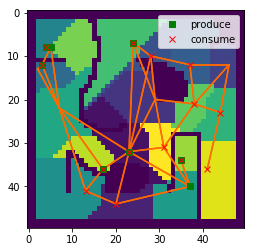

In [767]:
plt.imshow(voronoi)
for k,idcs in voronoi_neighbors.items():
    for i in idcs:
        plt.plot(
            [points[k,0],points[i,0]],
            [points[k,1],points[i,1]],
            color="#FF6A00"
        )
plt.plot(points[produce > 0,0],points[produce > 0,1],"s",color="green",label="produce")
plt.plot(points[consume > 0,0],points[consume > 0,1],"x",color="red",label="consume")
plt.legend()

In [768]:
surplus = produce - consume

In [769]:
surplus

array([ -5.50691086, -12.40226124,   0.        ,   0.        ,
       -10.86028022, -14.78769325,  -2.33866089,   0.        ,
         3.95150965, -10.55636848,   7.65424378,   0.        ,
        -7.14312885,   5.51289364,  -9.26222353,  13.77168652,
        -6.10667235,  -6.18886021,  -6.8063401 , -11.36317917])

In [770]:
produce.sum(), consume.sum()

(77.29386684084005, 149.7261123994368)

In [771]:
surplus.sum()

-72.43224555859675

In [772]:
if surplus.sum() < 0:
    # distribute negative surplus evenly across all consumers
    #granted = consume + surplus.sum() / consume.shape[0]
    
    # distribute negative surplus across all consumers weighted by consume
    assert(consume.sum() > 0)
    granted = consume + consume * surplus.sum() / consume.sum()
else:
    granted = consume

In [773]:
consume, granted

(array([13.26194984, 12.40226124,  0.        ,  0.        , 10.86028022,
        14.78769325, 12.82430066,  0.        ,  8.23726994, 10.55636848,
         0.        ,  0.        ,  7.14312885,  5.97198021,  9.26222353,
         0.        , 14.53112239, 11.71801453,  6.8063401 , 11.36317917]),
 array([6.84628331, 6.40248193, 0.        , 0.        , 5.60645728,
        7.63392554, 6.62035347, 0.        , 4.25236744, 5.44956739,
        0.        , 0.        , 3.68753347, 3.08294549, 4.78148441,
        0.        , 7.50147466, 6.04924979, 3.51367131, 5.86607134]))

In [774]:
produce.sum(), granted.sum()

(77.29386684084005, 77.29386684084004)

In [775]:
# use produces goods local first, the remaining produce is called the flux and can be transported 
# when there is no local production to provide for granted consume, i.e. the flux is negative, it must be transported there

In [776]:
flux = produce - granted

In [777]:
flux

array([ 0.90875567, -6.40248193,  0.        ,  0.        , -5.60645728,
       -7.63392554,  3.8652863 ,  0.        ,  7.93641214, -5.44956739,
        7.65424378,  0.        , -3.68753347,  8.40192836, -4.78148441,
       13.77168652,  0.92297537, -0.52009548, -3.51367131, -5.86607134])

In [778]:
# positive flux must be distributed to negative flux nodes via transportation with minimal transportation_costs

In [779]:
sending = flux > 0
receiving = flux < 0

In [780]:
sending, receiving

(array([ True, False, False, False, False, False,  True, False,  True,
        False,  True, False, False,  True, False,  True,  True, False,
        False, False]),
 array([False,  True, False, False,  True,  True, False, False, False,
         True, False, False,  True, False,  True, False, False,  True,
         True,  True]))

In [781]:
sending_idx = np.arange(num_points)[sending]
receiving_idx = np.arange(num_points)[receiving]

In [782]:
sending_idx,receiving_idx

(array([ 0,  6,  8, 10, 13, 15, 16]),
 array([ 1,  4,  5,  9, 12, 14, 17, 18, 19]))

In [783]:
np.sum(sending), np.sum(receiving)

(7, 9)

In [784]:
transport=np.zeros(shape=(np.sum(sending), np.sum(receiving)), dtype=float)

In [785]:
relevant_transportation_costs = np.array([[transportation_costs[i,k] for k in receiving_idx]
                                                                     for i in sending_idx])

In [786]:
relevant_transportation_costs

array([[17., 26., 30., 25., 27., 20.,  7., 41.,  9.],
       [44., 54., 58., 36., 55., 48., 26., 69., 37.],
       [51., 61., 65., 43., 62., 55., 33., 76., 44.],
       [18., 43., 38., 26., 35., 28., 24., 49., 17.],
       [43.,  5., 15., 51., 31., 24., 33., 45., 26.],
       [49., 59., 63., 41., 60., 53., 31., 74., 42.],
       [25., 50., 45., 33., 42., 35., 31., 56., 24.]])

In [787]:
transport*relevant_transportation_costs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [788]:
display(-flux[receiving], transport.sum(axis=0))
display(flux[sending], transport.sum(axis=1))

array([6.40248193, 5.60645728, 7.63392554, 5.44956739, 3.68753347,
       4.78148441, 0.52009548, 3.51367131, 5.86607134])

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([ 0.90875567,  3.8652863 ,  7.93641214,  7.65424378,  8.40192836,
       13.77168652,  0.92297537])

array([0., 0., 0., 0., 0., 0., 0.])

In [789]:
transport

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [790]:
# transport.sum(axis=0) == -flux[receiving]
# transport.sum(axis=1) == flux[sending]
# transport > 0
# min transport*transportation_costs

In [791]:
received = transport.sum(axis=0)
sent = transport.sum(axis=1)
missing = -flux[receiving] - received
available = flux[sending] - sent

In [792]:
received, missing, sent, available

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([6.40248193, 5.60645728, 7.63392554, 5.44956739, 3.68753347,
        4.78148441, 0.52009548, 3.51367131, 5.86607134]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.90875567,  3.8652863 ,  7.93641214,  7.65424378,  8.40192836,
        13.77168652,  0.92297537]))

In [793]:
relevant_transportation_costs

array([[17., 26., 30., 25., 27., 20.,  7., 41.,  9.],
       [44., 54., 58., 36., 55., 48., 26., 69., 37.],
       [51., 61., 65., 43., 62., 55., 33., 76., 44.],
       [18., 43., 38., 26., 35., 28., 24., 49., 17.],
       [43.,  5., 15., 51., 31., 24., 33., 45., 26.],
       [49., 59., 63., 41., 60., 53., 31., 74., 42.],
       [25., 50., 45., 33., 42., 35., 31., 56., 24.]])

In [794]:
# greedyly fill transport with lowest transportation_costs

In [795]:
def greedy_transport(transport, cost, receiving, sending):
    
    received = transport.sum(axis=0)
    sent = transport.sum(axis=1)
    missing = receiving - received
    available = sending - sent
    #print("missing", missing)
    #print("available", available)
    sel_valid_available = available>0
    sel_valid_missing = missing>0
    idx_valid_available = np.arange(len(sel_valid_available))[sel_valid_available]
    idx_valid_missing = np.arange(len(sel_valid_missing))[sel_valid_missing]
    #print("idx_valid_available", idx_valid_available)
    #print("idx_valid_missing", idx_valid_missing)
    if len(idx_valid_available) > 0 and len(idx_valid_missing) > 0:
        costs = np.array([
            [
                relevant_transportation_costs[i,k]
                for k in idx_valid_missing
            ]
            for i in idx_valid_available
        ])
        #print("costs")
        #print(costs)
        best_idx_valid = np.argmin(costs)
        best_idx_valid_missing = best_idx_valid % len(idx_valid_missing)
        best_idx_valid_available = best_idx_valid // len(idx_valid_missing)
        #print("best_idx_valid_available", best_idx_valid_available)
        #print("best_idx_valid_missing", best_idx_valid_missing)
        amount = min(available[idx_valid_available[best_idx_valid_available]], missing[idx_valid_missing[best_idx_valid_missing]])
        #print("amount", amount)
        #print("idx_valid_available[best_idx_valid_available]", idx_valid_available[best_idx_valid_available])
        #print("idx_valid_missing[best_idx_valid_missing]", idx_valid_missing[best_idx_valid_missing])
        new_transport = np.zeros_like(transport)
        new_transport[idx_valid_available[best_idx_valid_available],idx_valid_missing[best_idx_valid_missing]] = amount
        #print("new_transport")
        #print(new_transport)
        return new_transport
    else:
        return np.zeros_like(transport)

In [796]:
relevant_transportation_costs

array([[17., 26., 30., 25., 27., 20.,  7., 41.,  9.],
       [44., 54., 58., 36., 55., 48., 26., 69., 37.],
       [51., 61., 65., 43., 62., 55., 33., 76., 44.],
       [18., 43., 38., 26., 35., 28., 24., 49., 17.],
       [43.,  5., 15., 51., 31., 24., 33., 45., 26.],
       [49., 59., 63., 41., 60., 53., 31., 74., 42.],
       [25., 50., 45., 33., 42., 35., 31., 56., 24.]])

In [797]:
transport

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [798]:
g1 = greedy_transport(transport, relevant_transportation_costs, -flux[receiving], flux[sending])
transport+g1

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 5.60645728, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [799]:
g2 = greedy_transport(transport+g1, relevant_transportation_costs, -flux[receiving], flux[sending])
transport+g1+g2

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.52009548, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 5.60645728, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [800]:
g3 = greedy_transport(transport+g1+g2, relevant_transportation_costs, -flux[receiving], flux[sending])
transport+g1+g2+g3

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.52009548, 0.        , 0.38866019],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 5.60645728, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [801]:
g4 = greedy_transport(transport+g1+g2+g3, relevant_transportation_costs, -flux[receiving], flux[sending])
transport+g1+g2+g3+g4

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.52009548, 0.        , 0.38866019],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 5.60645728, 2.79547108, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [802]:
def greedy_transport_iterative(transport, cost, receiving, sending):
    result = transport.copy()
    ntransport = greedy_transport(result, cost, receiving, sending)
    while np.sum(ntransport) > 0:
        result += ntransport
        ntransport = greedy_transport(result, cost, receiving, sending)
    return result

In [803]:
transport_opt = greedy_transport_iterative(transport, relevant_transportation_costs, -flux[receiving], flux[sending])

In [804]:
print(transport_opt)

[[0.         0.         0.         0.         0.         0.
  0.52009548 0.         0.38866019]
 [0.         0.         0.         3.8652863  0.         0.
  0.         0.         0.        ]
 [0.         0.         4.42274083 0.         0.         0.
  0.         3.51367131 0.        ]
 [2.17683262 0.         0.         0.         0.         0.
  0.         0.         5.47741116]
 [0.         5.60645728 2.79547108 0.         0.         0.
  0.         0.         0.        ]
 [3.30267393 0.         0.41571362 1.58428109 3.68753347 4.78148441
  0.         0.         0.        ]
 [0.92297537 0.         0.         0.         0.         0.
  0.         0.         0.        ]]


In [805]:
print(transport_opt*relevant_transportation_costs)

[[  0.           0.           0.           0.           0.
    0.           3.64066835   0.           3.49794169]
 [  0.           0.           0.         139.15030678   0.
    0.           0.           0.           0.        ]
 [  0.           0.         287.4781542    0.           0.
    0.           0.         267.03901944   0.        ]
 [ 39.18298721   0.           0.           0.           0.
    0.           0.           0.          93.11598967]
 [  0.          28.03228641  41.93206617   0.           0.
    0.           0.           0.           0.        ]
 [161.83102262   0.          26.18995827  64.95552475 221.25200798
  253.41867382   0.           0.           0.        ]
 [ 23.07438435   0.           0.           0.           0.
    0.           0.           0.           0.        ]]


In [806]:
print((transport_opt*relevant_transportation_costs).sum())

1653.7909917276606


In [807]:
print(flux)

[ 0.90875567 -6.40248193  0.          0.         -5.60645728 -7.63392554
  3.8652863   0.          7.93641214 -5.44956739  7.65424378  0.
 -3.68753347  8.40192836 -4.78148441 13.77168652  0.92297537 -0.52009548
 -3.51367131 -5.86607134]


In [808]:
print(flux[sending])

[ 0.90875567  3.8652863   7.93641214  7.65424378  8.40192836 13.77168652
  0.92297537]


In [809]:
print(flux[receiving])

[-6.40248193 -5.60645728 -7.63392554 -5.44956739 -3.68753347 -4.78148441
 -0.52009548 -3.51367131 -5.86607134]


In [810]:
display(-flux[receiving], transport_opt.sum(axis=0))
display(flux[sending], transport_opt.sum(axis=1))


array([6.40248193, 5.60645728, 7.63392554, 5.44956739, 3.68753347,
       4.78148441, 0.52009548, 3.51367131, 5.86607134])

array([6.40248193, 5.60645728, 7.63392554, 5.44956739, 3.68753347,
       4.78148441, 0.52009548, 3.51367131, 5.86607134])

array([ 0.90875567,  3.8652863 ,  7.93641214,  7.65424378,  8.40192836,
       13.77168652,  0.92297537])

array([ 0.90875567,  3.8652863 ,  7.93641214,  7.65424378,  8.40192836,
       13.77168652,  0.92297537])

In [606]:
num_source_slots = np.round(((np.random.rand(num_points) < 0.5) * np.random.uniform(1,8,num_points)))

In [616]:
num_infinite_consumers = np.round(((np.random.rand(num_points) < 0.4) * np.random.uniform(1,3,num_points)))

In [628]:
num_construction_mat = ((np.random.rand(num_points) < 0.2) * 50 * np.round(np.random.uniform(1,10,num_points)))

In [632]:
num_construction_sites = 10
num_sources = 2 
num_

In [811]:
priority_construction = 1
priority_tower = 1
priority_upgrade = 2
priority_harvest = 2